1. Data Collection

In [1]:
# Data collection
import os
path = r'D:\sign language\SLR_Project\archive\Indian'

2. Features Extraction

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Paths
dataset_path = path  # <-- Set your dataset path
image_size = (224, 224)

# MediaPipe Hands setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

X = []
Y = []

def extract_hand_features(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    features = []

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks[:2]:
            for lm in hand_landmarks.landmark:
                features.extend([lm.x, lm.y, lm.z])

        if len(results.multi_hand_landmarks) == 1:
            features.extend([0] * 21 * 3)  # pad for second hand
    else:
        features.extend([0] * 21 * 3 * 2)  # pad for both hands

    return np.array(features, dtype=np.float32)

# Collect file paths
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Process images
for image_path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Processing Images"):
    img = cv2.imread(image_path)
    if img is None or img.size == 0:
        continue  # Skip empty or corrupted images

    features = extract_hand_features(img)
    X.append(features)
    Y.append(label)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Normalize features
if X.size > 0:
    X = (X - X.min()) / (X.max() - X.min())

# Save data
np.save('X.npy', X)
np.save('Y.npy', Y_encoded)
np.save('label_classes.npy', label_encoder.classes_)

print(f"Data saved! Total samples: {len(X)}")

Processing Images: 100%|██████████| 42745/42745 [37:09<00:00, 19.17it/s]  

Data saved! Total samples: 42745


In [5]:
x = np.load('X.npy')
y = np.load('Y.npy')
l = np.load('label_classes.npy')
print('X: ',x, 'Size: ', len(x))
print('Y: ',y, 'Size: ', len(y))
print('Label: ',l, 'No. of Classes: ', len(l))

X:  [[0.56985456 0.7952571  0.28558028 ... 0.28558055 0.28558055 0.28558055]
 [0.5677365  0.7973952  0.28558028 ... 0.28558055 0.28558055 0.28558055]
 [0.5716579  0.79616046 0.2855803  ... 0.28558055 0.28558055 0.28558055]
 ...
 [0.7913984  0.6608033  0.28558004 ... 0.5398819  0.41532862 0.21490039]
 [0.78914165 0.66271895 0.28558    ... 0.28558055 0.28558055 0.28558055]
 [0.791723   0.6586501  0.28558004 ... 0.53777415 0.4114106  0.22242007]] Size:  42745
Y:  [ 0  0  0 ... 34 34 34] Size:  42745
Label:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I'
 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'] No. of Classes:  35


3. Model Training

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load data
X = np.load('X.npy')
Y = np.load('Y.npy')

# One-hot encode labels
num_classes = len(np.unique(Y))
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Define model
model = Sequential([
    Dense(256, input_shape=(126,), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Train model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/50
1069/1069 [==============================] - 3s 2ms/step - loss: 1.8255 - accuracy: 0.4741 - val_loss: 0.5004 - val_accuracy: 0.9067
Epoch 2/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.4570 - accuracy: 0.8728 - val_loss: 0.1403 - val_accuracy: 0.9729
Epoch 3/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.2389 - accuracy: 0.9345 - val_loss: 0.0941 - val_accuracy: 0.9784
Epoch 4/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.1633 - accuracy: 0.9538 - val_loss: 0.0663 - val_accuracy: 0.9841
Epoch 5/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.1316 - accuracy: 0.9631 - val_loss: 0.0576 - val_accuracy: 0.9861
Epoch 6/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.1122 - accuracy: 0.9667 - val_loss: 0.0516 - val_accuracy: 0.9860
Epoch 7/50
1069/1069 [==============================] - 2s 2ms/step - loss: 0.1014 - accuracy: 0.9716 - val_loss: 0.0491 - val_accuracy:

Model Evaluation

In [12]:
# Evaluate
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100: .2f}%")
print(f"Loss: {loss * 100: .2f}%")

268/268 [==============================] - 0s 981us/step - loss: 0.0360 - accuracy: 0.9890
Test Accuracy:  98.90%
Loss:  3.60%


Saving Model

In [14]:
# Save model
model.save('slr_test1_model.h5')


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
model = load_model('slr_test1_model.h5')

# Load data
X = np.load('X.npy')
Y = np.load('Y.npy')
label_classes = np.load('label_classes.npy')

# One-hot encode labels
num_classes = len(np.unique(Y))
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Predict on test set
Y_pred_probs = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Accuracy
accuracy = accuracy_score(Y_true, Y_pred)

# Precision, Recall, F1 (macro average for multiclass)
precision = precision_score(Y_true, Y_pred, average='macro')
recall = recall_score(Y_true, Y_pred, average='macro')
f1 = f1_score(Y_true, Y_pred, average='macro')

print(f"Accuracy:  {accuracy * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall:    {recall * 100:.4f}")
print(f"F1 Score:  {f1 * 100:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=label_classes))


268/268 [==============================] - 0s 793us/step
Accuracy:  98.9005
Precision: 99.1463
Recall:    98.9908
F1 Score:  98.9916

Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       240
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       240
           A       1.00      1.00      1.00       240
           B       1.00      0.98      0.99       240
           C       1.00      0.88      0.93       289
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.

Plotting Accuracy & Loss Graphs

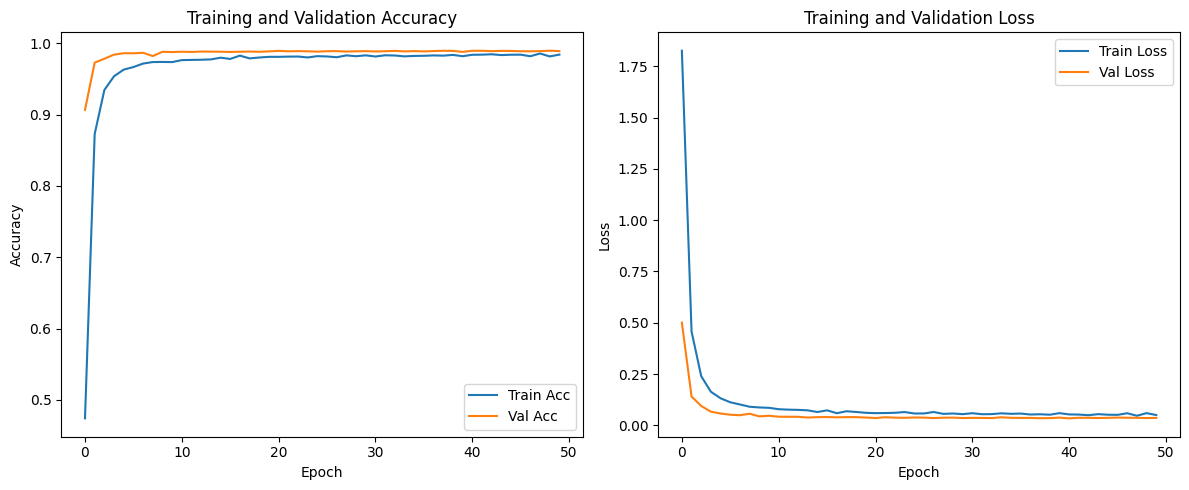

In [15]:

# Plot accuracy & loss graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


Prediction of Model
- Predicting test cases

In [16]:
# Prediction
from tensorflow.keras.models import load_model
model = load_model('slr_test1_model.h5')
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(Y_test, axis=1)

# Display first 10 comparisons
label_classes = np.load("label_classes.npy")
print("\nPrediction vs Actual Labels (First 10 Samples):")
for i in range(10):
    predicted_class = label_classes[predicted_labels[i]]
    actual_class = label_classes[actual_labels[i]]
    print(f"Predicted: {predicted_class}  |  Actual: {actual_class}")


268/268 [==============================] - 0s 816us/step

Prediction vs Actual Labels (First 10 Samples):
Predicted: 3  |  Actual: 3
Predicted: S  |  Actual: S
Predicted: Y  |  Actual: Y
Predicted: 1  |  Actual: 1
Predicted: 8  |  Actual: 8
Predicted: 1  |  Actual: 1
Predicted: Y  |  Actual: Y
Predicted: U  |  Actual: U
Predicted: Q  |  Actual: P
Predicted: U  |  Actual: U


In [20]:
import random
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style, init

# Initialize colorama for colored console output
init()

# Load the model and label classes
model = load_model('slr_test1_model.h5')
label_classes = np.load('label_classes.npy')

def predict_random_samples(X_test, Y_test, num_samples=5):
    # Get random indices
    test_size = len(X_test)
    random_indices = random.sample(range(test_size), num_samples)
    
    # Track statistics
    correct_predictions = 0
    total_confidence = 0
    
    # Make predictions
    print("\nRandom Predictions from Test Dataset:")
    print("=" * 60)
    
    for i, idx in enumerate(random_indices, 1):
        # Get the sample and reshape if needed
        sample = X_test[idx:idx+1]
        
        # Predict
        prediction = model.predict(sample, verbose=0)
        predicted_label = label_classes[np.argmax(prediction)]
        actual_label = label_classes[np.argmax(Y_test[idx])]
        confidence = np.max(prediction) * 100
        
        # Check if prediction is correct
        is_correct = predicted_label == actual_label
        if is_correct:
            correct_predictions += 1
        total_confidence += confidence
        
        # Print results with colors
        print(f"\nSample {i}/{num_samples}:")
        print(f"Predicted Sign: {predicted_label}")
        print(f"Actual Sign: {actual_label}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Print status with color
        if is_correct:
            print(Fore.GREEN + "Status: ✓ CORRECT" + Style.RESET_ALL)
        else:
            print(Fore.RED + "Status: ✗ INCORRECT" + Style.RESET_ALL)
        
        print("-" * 60)
    
    # Print summary statistics
    accuracy = (correct_predictions / num_samples) * 100
    avg_confidence = total_confidence / num_samples
    
    print("\nSummary Statistics:")
    print(f"Total Samples: {num_samples}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Average Confidence: {avg_confidence:.2f}%")
    
    # Visual representation of accuracy
    print("\nAccuracy Visualization:")
    correct_bar = "█" * correct_predictions
    incorrect_bar = "█" * (num_samples - correct_predictions)
    print(Fore.GREEN + correct_bar + Fore.RED + incorrect_bar + Style.RESET_ALL)
    print(f"Each block represents one prediction")

# Make random predictions
predict_random_samples(X_test, Y_test, num_samples=5)


Random Predictions from Test Dataset:

Sample 1/5:
Predicted Sign: N
Actual Sign: N
Confidence: 100.00%
Status: ✓ CORRECT
------------------------------------------------------------

Sample 2/5:
Predicted Sign: Z
Actual Sign: Z
Confidence: 100.00%
Status: ✓ CORRECT
------------------------------------------------------------

Sample 3/5:
Predicted Sign: O
Actual Sign: O
Confidence: 100.00%
Status: ✓ CORRECT
------------------------------------------------------------

Sample 4/5:
Predicted Sign: N
Actual Sign: N
Confidence: 100.00%
Status: ✓ CORRECT
------------------------------------------------------------

Sample 5/5:
Predicted Sign: 5
Actual Sign: 5
Confidence: 100.00%
Status: ✓ CORRECT
------------------------------------------------------------

Summary Statistics:
Total Samples: 5
Correct Predictions: 5
Accuracy: 100.00%
Average Confidence: 100.00%

Accuracy Visualization:
█████
Each block represents one prediction


Confusion Matrix

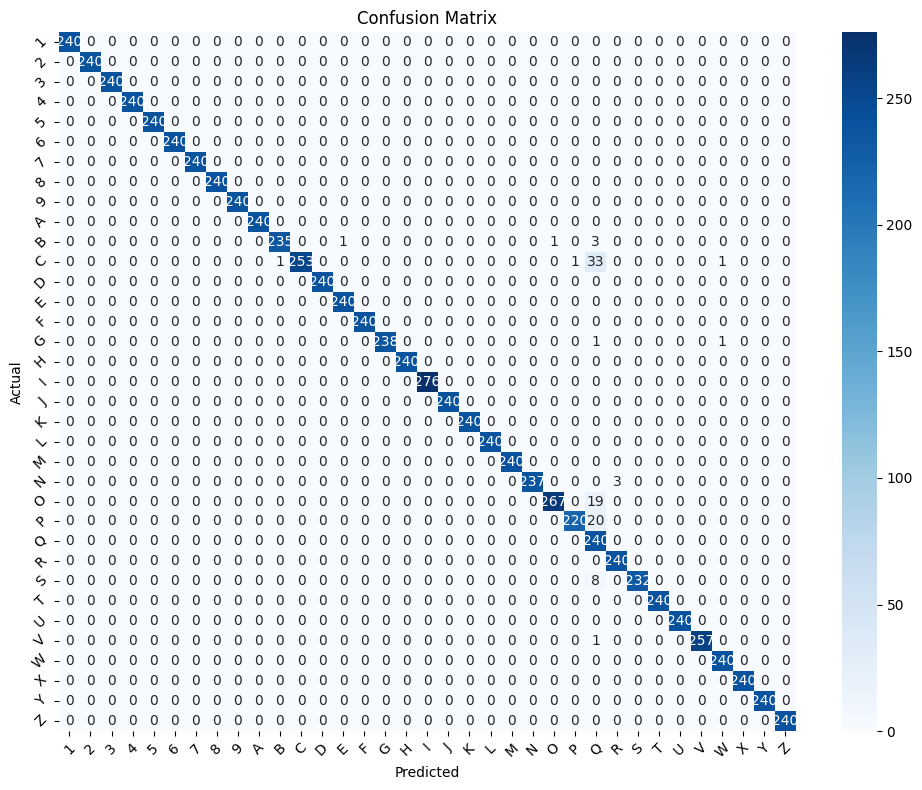

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_classes, yticklabels=label_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Speech in webcam

In [2]:
# Speech in webcam
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from collections import Counter
import pyttsx3
import threading
import time

# Initialize text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)  # Speed of speech
engine.setProperty('volume', 0.9)  # Volume (0-1)

# Global variables for speech control
last_spoken_time = 0
SPEECH_COOLDOWN = 2.0  # Seconds between speeches
current_sign = None
speech_lock = threading.Lock()

def speak_sign(text):
    global last_spoken_time
    current_time = time.time()
    
    with speech_lock:
        if current_time - last_spoken_time >= SPEECH_COOLDOWN:
            engine.say(text)
            engine.runAndWait()
            last_spoken_time = current_time

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
mp_draw = mp.solutions.drawing_utils

# Load the model and labels
model = load_model('slr_test1_model.h5')
label_classes = np.load('label_classes.npy')

# Constants
HISTORY_SIZE = 10
CONFIDENCE_THRESHOLD = 65
STABLE_PREDICTIONS_REQUIRED = 6

def extract_hand_features(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    features = []
    
    if results.multi_hand_landmarks:
        hands_landmarks = results.multi_hand_landmarks[:2]
        
        if len(hands_landmarks) == 2:
            if hands_landmarks[0].landmark[0].x > hands_landmarks[1].landmark[0].x:
                hands_landmarks = hands_landmarks[::-1]
        
        for hand_landmarks in hands_landmarks:
            x_coords = [lm.x for lm in hand_landmarks.landmark]
            y_coords = [lm.y for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            for lm in hand_landmarks.landmark:
                norm_x = (lm.x - x_min) / (x_max - x_min) if x_max > x_min else 0
                norm_y = (lm.y - y_min) / (y_max - y_min) if y_max > y_min else 0
                features.extend([norm_x, norm_y, lm.z])
            
            mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        if len(hands_landmarks) == 1:
            features.extend([0] * 21 * 3)
    else:
        features.extend([0] * 21 * 3 * 2)
    
    return np.array(features, dtype=np.float32)

# Initialize webcam
cap = cv2.VideoCapture(0)

# For prediction smoothing
prediction_history = []
prediction_labels = []

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        features = extract_hand_features(frame)
        
        if len(features) > 0:
            features = features.reshape(1, -1)
            features = (features - features.min()) / (features.max() - features.min() + 1e-8)
            
            prediction = model.predict(features, verbose=0)
            
            prediction_history.append(prediction[0])
            if len(prediction_history) > HISTORY_SIZE:
                prediction_history.pop(0)
            
            avg_prediction = np.mean(prediction_history, axis=0)
            predicted_label = label_classes[np.argmax(avg_prediction)]
            confidence = np.max(avg_prediction) * 100
            
            prediction_labels.append(predicted_label)
            if len(prediction_labels) > HISTORY_SIZE:
                prediction_labels.pop(0)
            
            label_counts = Counter(prediction_labels)
            most_common_label = label_counts.most_common(1)[0]
            
            if (most_common_label[1] >= STABLE_PREDICTIONS_REQUIRED and 
                confidence > CONFIDENCE_THRESHOLD):
                text = f"{most_common_label[0]} ({confidence:.1f}%)"
                cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                           1, (0, 255, 0), 2, cv2.LINE_AA)
                
                stability = (most_common_label[1] / HISTORY_SIZE) * 100
                cv2.putText(frame, f"Stability: {stability:.0f}%", (10, 90),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                # Speak the sign if it's stable and different from the last one
                if most_common_label[0] != current_sign:
                    current_sign = most_common_label[0]
                    # Start speech in a separate thread to avoid blocking
                    threading.Thread(target=speak_sign, args=(current_sign,)).start()
            else:
                cv2.putText(frame, "Waiting for stable gesture...", (10, 50),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                current_sign = None
        
        # Display hand detection status
        if len(features) > 0:
            cv2.putText(frame, "Hands Detected", (10, frame.shape[0] - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        else:
            cv2.putText(frame, "No Hands Detected", (10, frame.shape[0] - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            current_sign = None
        
        cv2.imshow('Sign Language Recognition', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    engine.stop()